In [1]:
import numpy as np
import pandas as pd 
import glob
import imageio
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

from numpy.random import randn
from numpy.random import randint
import time
from IPython import display
import cv2
!pip install imutils
from imutils import paths

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

np.random.seed(42)
tf.random.set_seed(42)

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=072ada6bc95e92cb6c191345d030a27b7d87dd591d1ec8dbeaf059571338d1d3
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
class settings:
    debug = False
    imsize = 64
    rgb = True
    latent_dim = 256
    n_samples = 0
    n_epochs = 25
    batch_size = 16

    if rgb:
        channels = 3
    else:
        channels = 1
        
    if debug:
        n_epochs = 70

In [3]:
def plotExampleImage(img_n):
    img = cv2.imread(impaths[img_n])
    np.shape(img)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))    
    plt.axis('off')

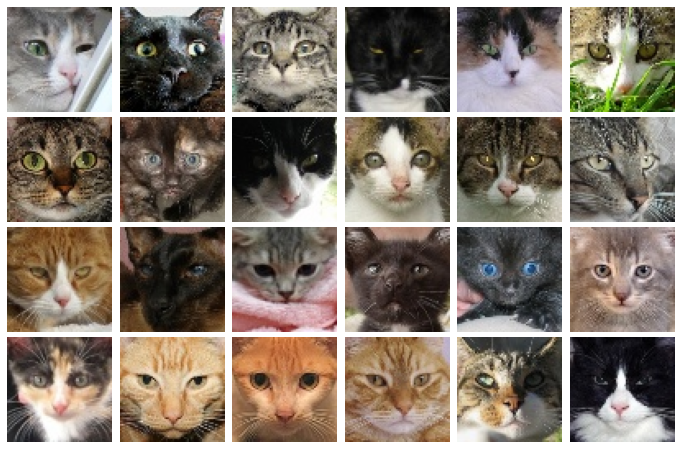

In [4]:
impaths = list(paths.list_images("../input/cats-faces-64x64-for-generative-models/cats"))

plt.figure(figsize=(12,8))
for k in range(24):
    plt.subplot(4,6,k+1)
    plotExampleImage(k)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [5]:
ds = []
if settings.debug:
    settings.n_samples = 16*settings.batch_size
else:
    settings.n_samples = len(impaths)

for i in range(0,settings.n_samples):  
    image = cv2.imread(impaths[i])
    if settings.rgb:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)   
    image = cv2.resize(image, (settings.imsize,settings.imsize))
    ds.append(image)
    
train_images = np.array(ds)
train_images = train_images.reshape(train_images.shape[0],64,64,3)
train_images = (train_images - 127.5) / 127.5 

BUFFER_SIZE = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(settings.batch_size)

In [6]:
def define_discriminator(in_shape=(settings.imsize,settings.imsize,settings.channels)):
    init = RandomNormal(mean=0.0, stddev=0.02)
    
    model = tf.keras.Sequential(name='Discriminator')
    model.add(Conv2D(256, (5,5), padding='same', input_shape=in_shape,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (5,5), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (5,5), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
  
    model.add(Flatten())
    model.add(Dropout(0.05))
    model.add(Dense(1, activation='sigmoid',kernel_initializer=init))
    return model

In [ ]:
def define_generator(latent_dim):
    init = RandomNormal(mean=0.0, stddev=0.02)
    model = tf.keras.Sequential(name='Generator')
    
    n_filters = 128 * 8 * 8
    model.add(Dense(n_filters, input_dim=latent_dim,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))

    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
 
    model.add(Conv2DTranspose(256, (4,4), strides=(1,1), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(256, (4,4), strides=(1,1), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same',use_bias=False))
    return model

In [8]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) 

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - np.random.random(real_output.shape)*0.2, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output)+ np.clip(-0.2 + np.random.random(fake_output.shape)*0.4,0,None), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

¤¤¤ Generator ¤¤¤:
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              2105344   
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16

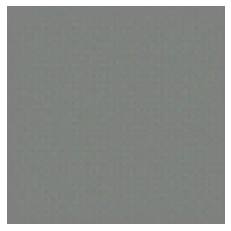

In [10]:
generator = define_generator(settings.latent_dim)
discriminator = define_discriminator()

generator_optimizer     = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5 )

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

noise = tf.random.normal([1, settings.latent_dim])
generated_image = generator(noise, training=False)
testimg = np.uint8(generated_image[0, :, :, :] * 127.5 + 127.5)
plt.imshow(testimg)
plt.axis('off')

print('¤¤¤ Generator ¤¤¤:')
generator.summary()
print('\n\n¤¤¤ Discriminator ¤¤¤:')
discriminator.summary()

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
noise_dim = settings.latent_dim
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
tf.config.run_functions_eagerly(True)
@tf.function
def train_step(images):
    noise = tf.random.normal([settings.batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        real_predict = np.array(np.array(real_output)>0.5)
        real_acc = 1-np.sum(np.abs(real_predict-np.ones(np.shape(real_predict)))) /len(real_predict)

        fake_predict = np.array(np.array(fake_output)>0.5)
        fake_acc = 1-np.sum(np.abs(fake_predict-np.zeros(np.shape(fake_predict)))) /len(fake_predict)

        idx = (-fake_output.numpy()).argsort(0).reshape((-1,))

        gen_loss  = generator_loss(fake_output[fake_output>fake_output[idx[int(len(idx)/2)]]*0.9])
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator     = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_acc, fake_acc

In [14]:
def plot_trainingMetrics(G_losses, D_losses, all_gl, all_dl, epoch, real_acc_full, fake_acc_full, all_racc, all_facc, sub_epoch_vect):
    colorG = np.array([195, 60, 162])/255 
    colorD = np.array([61, 194, 111])/255
    colorR = np.array([207, 91, 48])/255
    colorF = np.array([12, 181, 243])/255
    plt.figure(figsize=(10,5))
    plt.title("Generator and discriminator loss for training step {}".format(sub_epoch_vect))
    plt.plot(G_losses,label="Generator",color=colorG)
    plt.plot(D_losses,label="Discriminator",color=colorD)
    plt.xlabel("Iterations in one training step")
    plt.ylabel("Loss")
    plt.legend()
    ymax = plt.ylim()[1]
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(sub_epoch_vect,all_gl,label='Generator',color=colorG)
    plt.plot(sub_epoch_vect,all_dl,label='Discriminator',color=colorD)
    plt.title('All Time Loss')
    plt.xlabel("Iterations")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title("All Time Accuracy")
    plt.plot(sub_epoch_vect, all_racc,label="Acc: Real",color=colorR)
    plt.plot(sub_epoch_vect, all_facc,label="Acc: Fake",color=colorF)
    plt.xlabel("Iterations")
    plt.ylabel("Acc")
    plt.legend()
    plt.show()

In [15]:
def train(dataset, epochs):
    all_gl = np.array([])
    all_dl = np.array([])
    all_racc = np.array([])
    all_facc = np.array([])
    sub_epoch_vect = []

    sub_epoch = 0
    n_batches = train_dataset.cardinality().numpy()
    for epoch in range(epochs):
        print('Starting eoch: ' +str(epoch))
        start = time.time()
        
        G_loss = [] 
        D_loss = []
        real_acc_full = []
        fake_acc_full = []
        global_step = 0
        
        for image_batch in dataset:
            g_loss,d_loss, real_acc, fake_acc = train_step(image_batch)
            global_step = global_step + 1
            sub_epoch = sub_epoch+1
            G_loss.append(g_loss)
            D_loss.append(d_loss)
            real_acc_full.append(real_acc)
            fake_acc_full.append(fake_acc)
            
            if epoch<2:
                save_subepoch = 150
            else:
                save_subepoch = 1000
            
            if (sub_epoch % save_subepoch)==0:
                all_gl   = np.append(all_gl,np.mean(np.array([G_loss])))
                all_dl   = np.append(all_dl,np.mean(np.array([D_loss])))
                all_racc = np.append(all_racc,np.mean(np.array([real_acc_full])))
                all_facc = np.append(all_facc,np.mean(np.array([fake_acc_full])))
                sub_epoch_vect=np.append(sub_epoch_vect,sub_epoch)

                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch,
                                        sub_epoch + 1,
                                        seed)
                plot_trainingMetrics(G_loss, D_loss, all_gl, all_dl, sub_epoch, real_acc_full, fake_acc_full, all_racc, all_facc, sub_epoch_vect )

                print ('Time for epoch {}, global_step {}, is {} sec'.format(epoch + 1, global_step, time.time()-start))

        dataset.shuffle
        checkpoint.save(file_prefix = checkpoint_prefix)
    generate_and_save_images(generator, epoch,
                                        sub_epoch + 1,
                                        seed)

In [16]:
def generate_and_save_images(model, epoch, sub_epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(12, 12))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int32(np.array(predictions[i, :, :, :]) * 127.5 + 127.5)) 
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('image_at_epoch_{:04d}_subepoch{:08d}.png'.format(epoch,sub_epoch))
    plt.show()

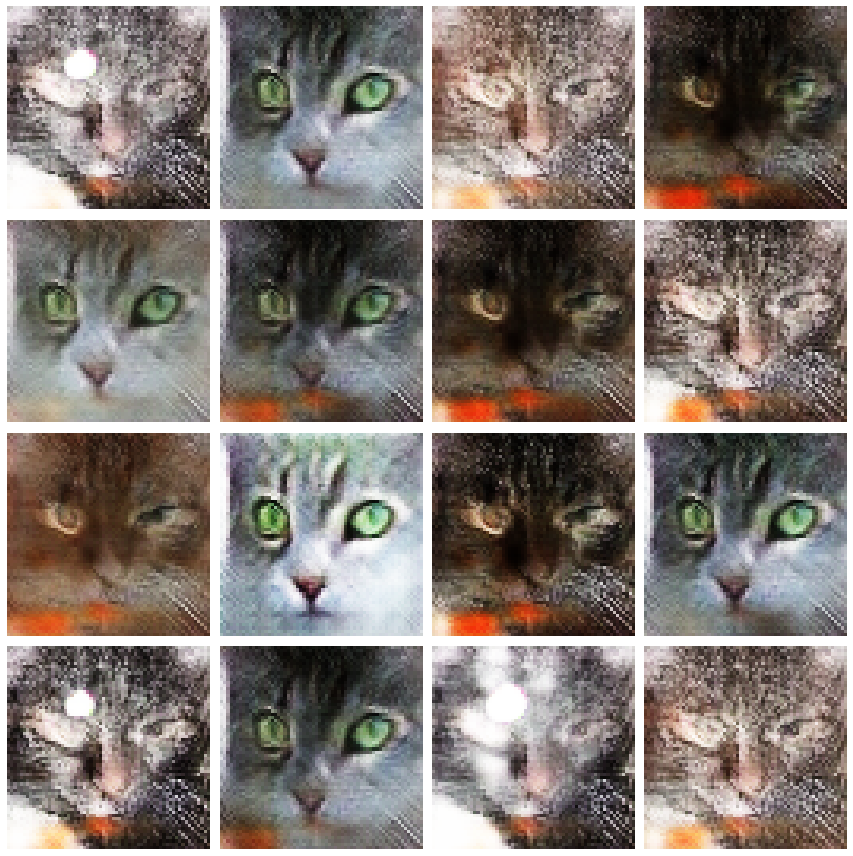

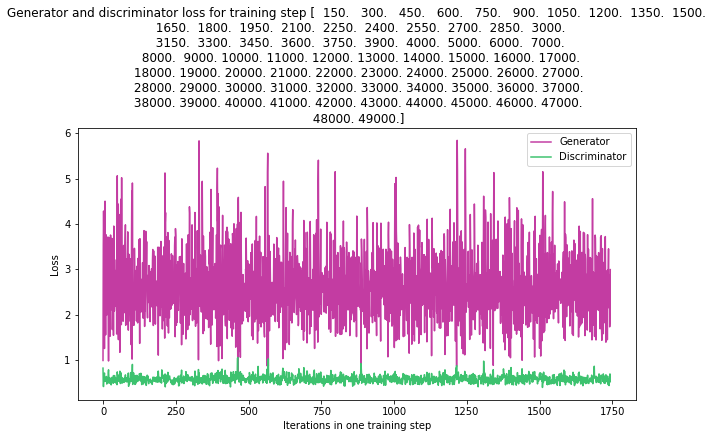

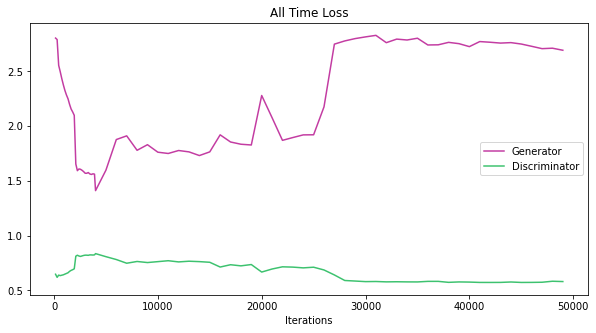

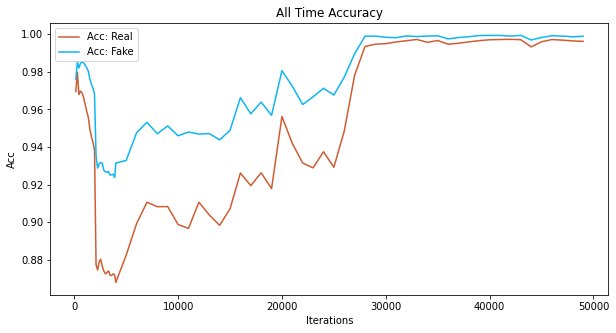

Time for epoch 25, global_step 1744, is 660.4409317970276 sec


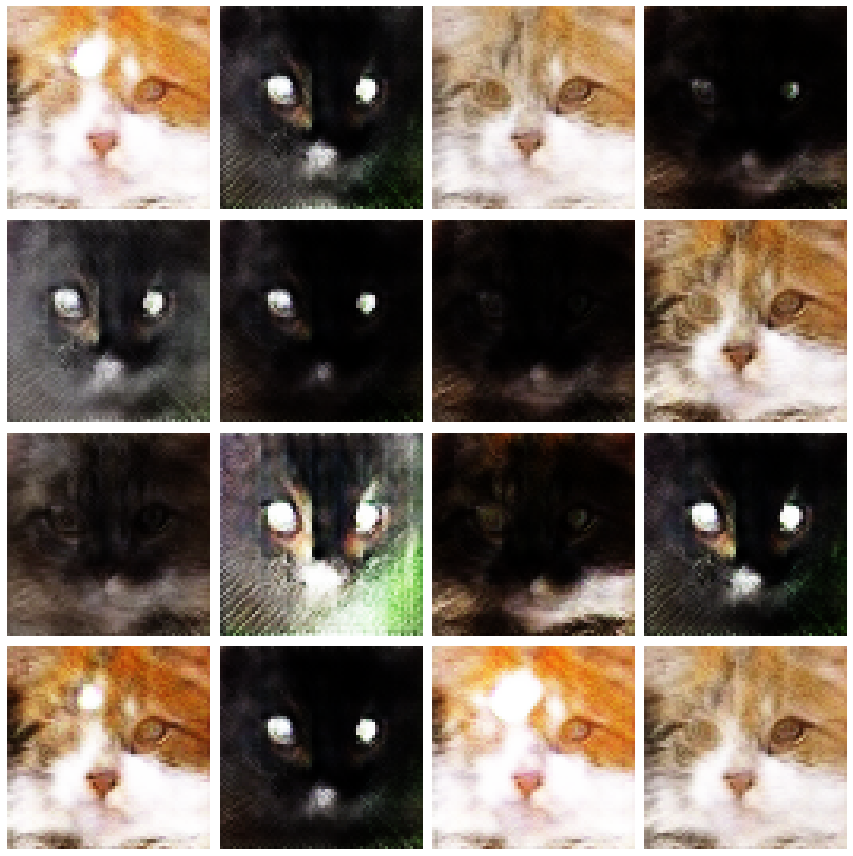

In [17]:
train(train_dataset, settings.n_epochs)

In [18]:
anim_file = 'catgan_progress.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [19]:
def loadCheckpointAndGenerateImages(checkpointNo):
    checkpoint.restore('./training_checkpoints/ckpt-' +str(checkpointNo))
    
    n_sampels_peritt = 64
    n_itt = 16
    n_images = 16
    noise_dim=256

    pred_best  = np.zeros(n_images)
    pred_worst = np.ones(n_images)
    best_images  = np.zeros((n_images,64,64,3))
    worst_images = np.zeros((n_images,64,64,3))
    total_fake_pred = []
    for k in range(n_itt):
        seed_Nimgs = tf.random.normal([n_sampels_peritt, noise_dim])
        generated_images = generator(seed_Nimgs, training=False)
        fake_prediction = discriminator(generated_images, training=False)
        total_fake_pred.append(np.array(fake_prediction))
        idx = (-fake_prediction.numpy()).argsort(0).reshape((-1,))
        idx_nbest  = idx[0:16]
        idx_nworst = idx[-16::]    
        pred_best_temp  = fake_prediction[idx_nbest]
        pred_worst_temp = fake_prediction[idx_nworst]
        best_images_temp  = generated_images[idx_nbest, :,:,:]
        worst_images_temp = generated_images[idx_nworst,:,:,:]
        for k,x in enumerate(pred_best_temp):
            idx_list = pred_best<np.array(x)      
            if any(idx_list):
                i = idx_list.nonzero()[0][0]
                pred_best[i] = x
                best_images[i,:,:,:] = np.array(best_images_temp[k,:,:,:])
        for k,x in reversed(list(enumerate(pred_worst_temp))):
            idx_list = pred_worst>np.array(x)
            if any(idx_list):
                i = idx_list.nonzero()[0][0]
                pred_worst[i] = x
                worst_images[i,:,:,:] = np.array(worst_images_temp[k,:,:,:])

    fig = plt.figure(figsize=(10, 10))
    seed_Nimgs = tf.random.normal([n_sampels_peritt, noise_dim])
    generated_images = generator(seed_Nimgs, training=False)
    fake_prediction = np.array(discriminator(generated_images, training=False))
    fig.suptitle('Examples of random generated images')
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int32(generated_images[i, :, :, :] * 127.5 + 127.5)) 
        plt.text(2,2,'p: {0:.3f}'.format(fake_prediction[i][0]) ,color='y',backgroundcolor='k')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('N_randomImages_final_cp' +str(checkpointNo) +'.png')
    plt.show()
    
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Examples of generated images the discriminator scored high')
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int32(best_images[i, :, :, :] * 127.5 + 127.5)) 
        plt.text(2,2,'p: {0:.3f}'.format(pred_best[i]) ,color='y',backgroundcolor='k')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('N_bestImages_final_cp' +str(checkpointNo) +'.png')
    plt.show()
    
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Examples of generated images the discriminator scored low')
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int32(worst_images[i, :, :, :] * 127.5 + 127.5)) 
        plt.text(2,2,'p: {0:.3f}'.format(pred_worst[i]) ,color='y',backgroundcolor='k')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('N_worstImages_final_cp' +str(checkpointNo) +'.png')
    plt.show()

    fig = plt.figure(figsize=(10, 5))
    plt.hist(np.array(total_fake_pred).flatten(),25,color=[0.72,0.30,0.3])
    plt.title('Distribution of discriminator scores on generated images ')
    plt.xlabel('Discriminator Scores')
    plt.savefig('DistributionOfScores' +str(checkpointNo) +'.png')
    plt.show()

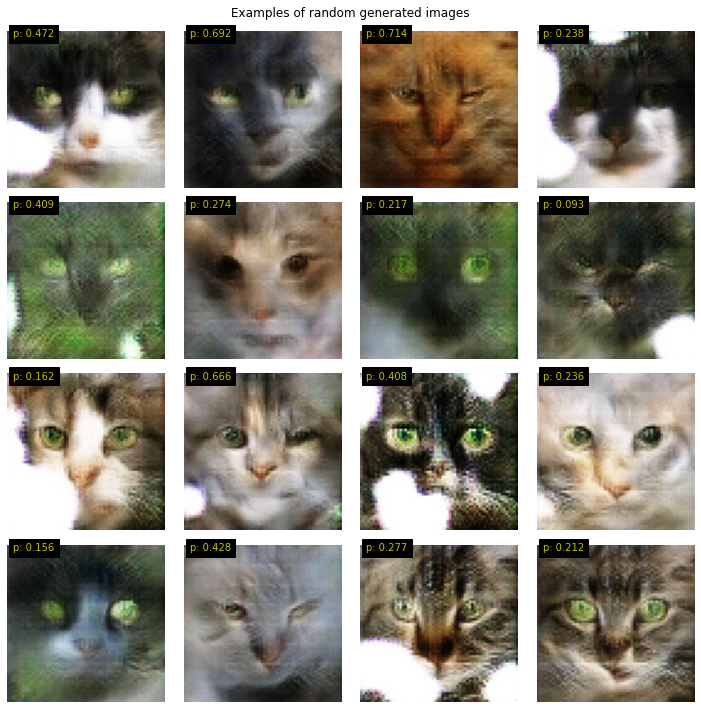

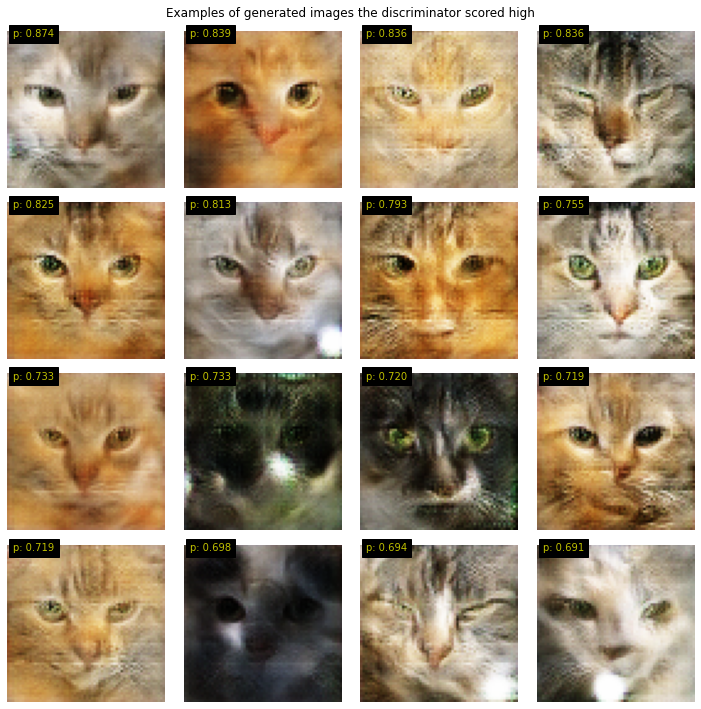

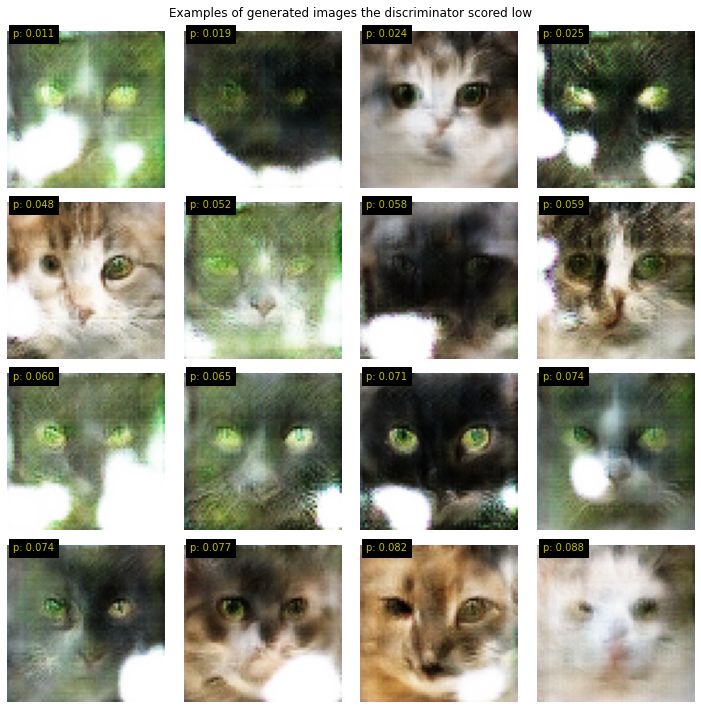

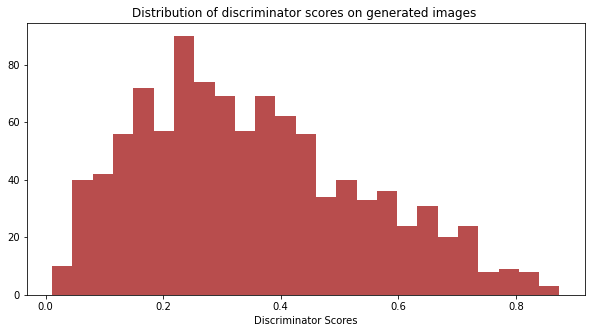

In [20]:
loadCheckpointAndGenerateImages(2)

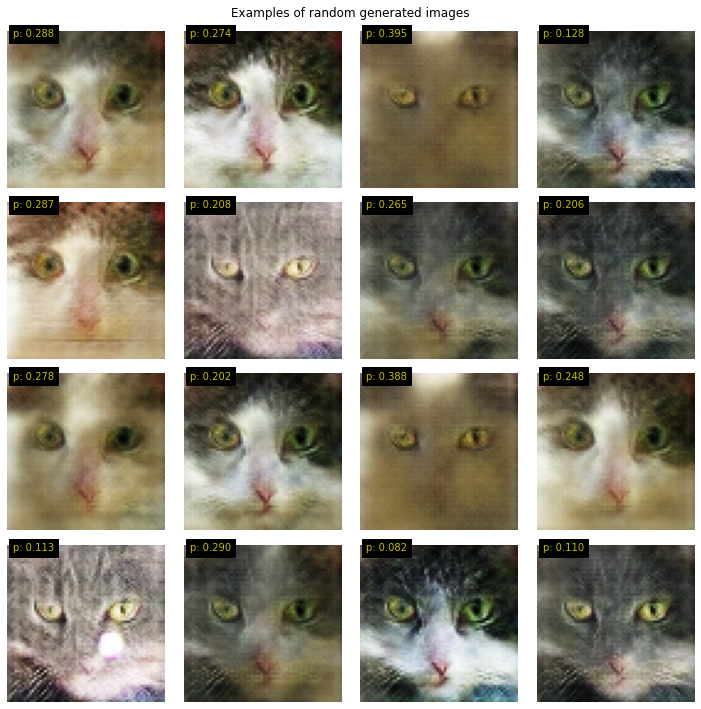

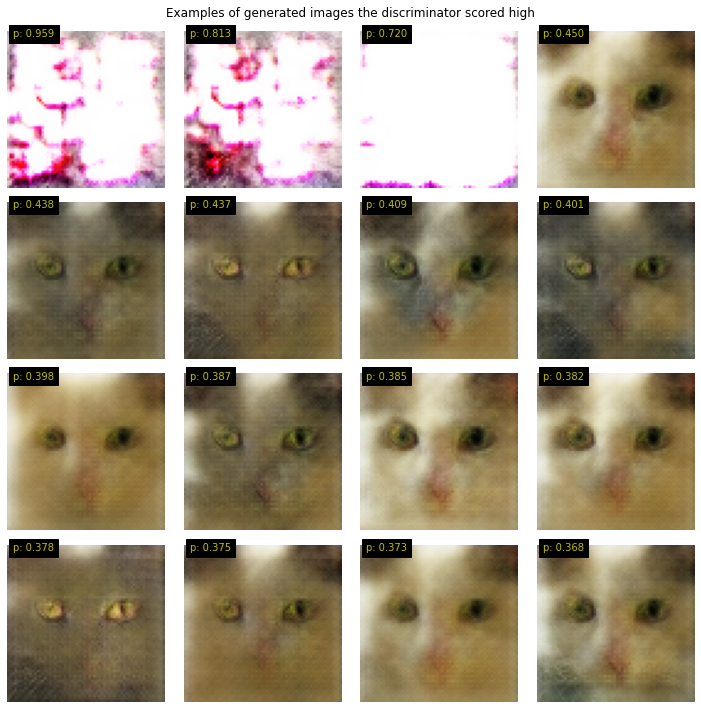

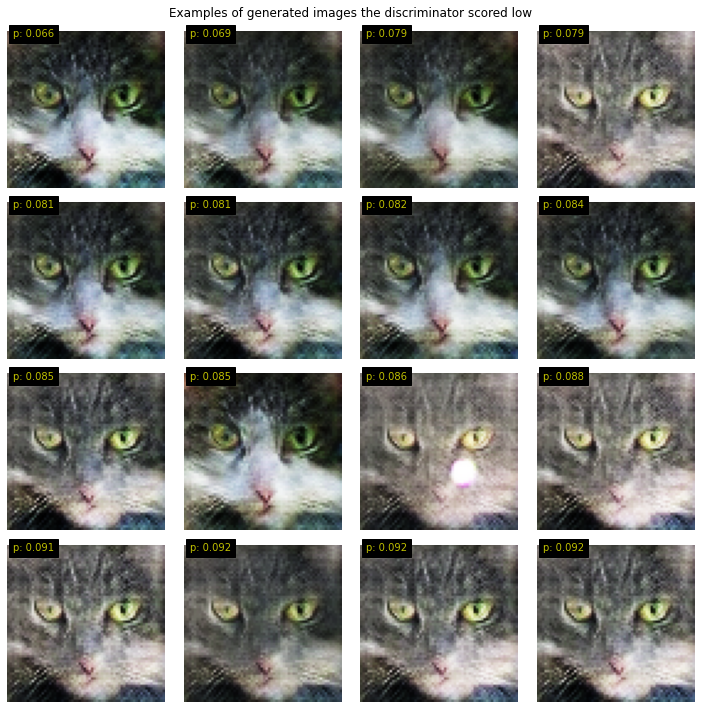

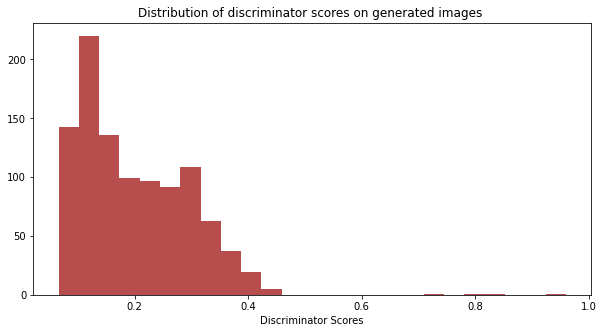

In [21]:
loadCheckpointAndGenerateImages(20)

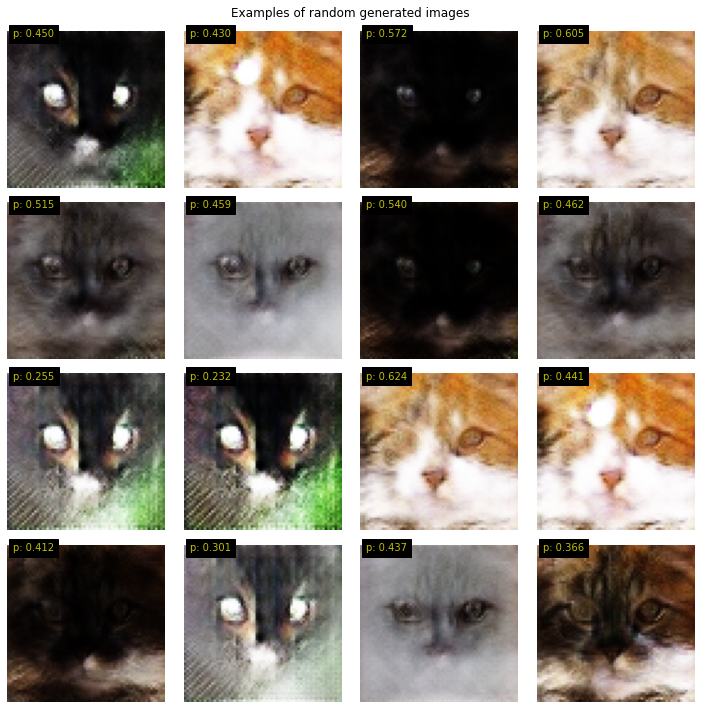

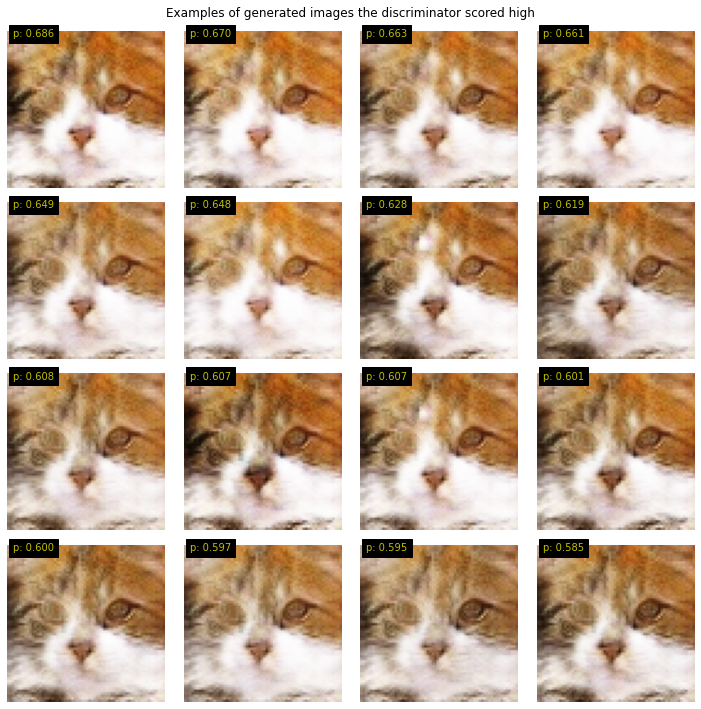

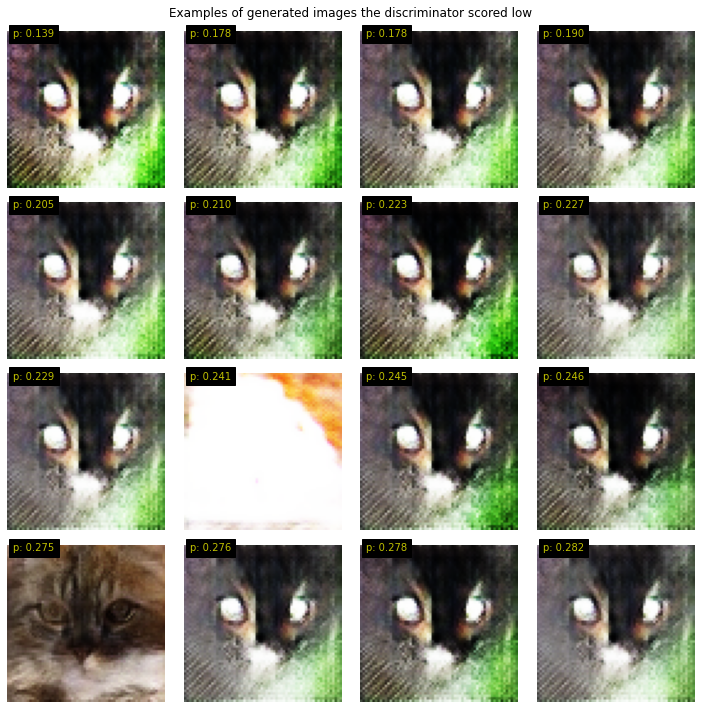

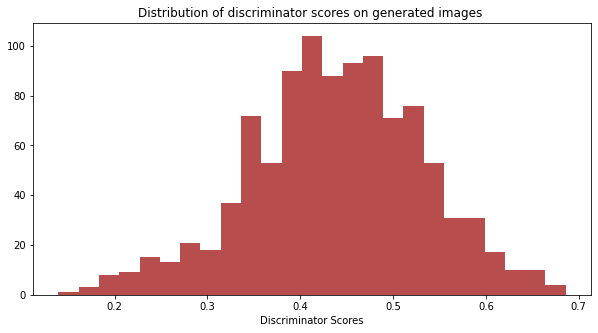

In [22]:
loadCheckpointAndGenerateImages(25)